In [39]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal
from scipy.fft import fft
from scipy.signal import butter, lfilter
import os
from utils import *
from preprocess import *

In [3]:
data_dir = "C:/Users/Jayde/Desktop/library/zebra_finch/data/"
anno = pd.read_csv(f'{data_dir}annotations.csv')

audio = []
srs= []

#adding the audio data to the dataframe
for _, row in anno.iterrows():
    recording, sr = librosa.load(f'{data_dir}vocalizations/{row.fn}')
    audio.append(recording)
    srs.append(sr)
    
anno['audio'] = audio



KeyboardInterrupt: 

In [2]:
recs = []
srs = []
file_names= []
call_types = []
names = []


data_dir = "C:/Users/Jayde/Desktop/library/zebra_finch/data/AdultVocalizations/"
for file_name in os.listdir(data_dir):
    recording, sr = librosa.load(f'{data_dir}{file_name}', sr = None)
    #print(file)
    try:
        name, file= file_name.split("_")
        date, call_type, rendition= file.split("-")
        call_type = call_type[:2]
        #print(name, date, call_type)
        recs.append(recording)
        names.append(name)
        file_names.append(file_name)
        call_types.append(call_type)
        srs.append(sr)
    except:
        print(f"skipped {file}")
        continue

print(f"processed {len(recs)} out of {len(os.listdir(data_dir))}")

processed 2969 out of 2969


In [3]:
df = pd.DataFrame()
df["file_name"] = file_names
df["name"] = names
df["call_type"]= call_types
#df["sr"] = srs
df["rec"] = recs
durations = [x.shape[0] / 44100 for x in recs]
df["duration"] = durations


In [4]:
df.head()

,file_name,name,call_type,rec,duration
0,BlaBla0506_110302-AggC-04.wav,BlaBla0506,Ag,"[-1.5258789e-05, -0.0009918213, 3.0517578e-05,...",0.308118
1,BlaBla0506_110302-AggC-05.wav,BlaBla0506,Ag,"[0.0001373291, 0.00021362305, 0.00062561035, 0...",0.599184
2,BlaBla0506_110302-DC-01.wav,BlaBla0506,DC,"[0.00015258789, 0.0002746582, -0.0005340576, -...",0.238594
3,BlaBla0506_110302-DC-02.wav,BlaBla0506,DC,"[0.002105713, 0.0018157959, 0.0018157959, 0.00...",0.261111
4,BlaBla0506_110302-DC-05.wav,BlaBla0506,DC,"[-4.5776367e-05, -0.00032043457, -0.0006408691...",0.253220


In [5]:
df.describe()

,duration
count,2969.000000
mean,0.338989
std,0.719706
min,0.032494
25%,0.085442
50%,0.127551
75%,0.246100
max,11.705079


In [6]:
slice_lens = [16384, 32768, 65536]
for slice_len in slice_lens:
    dur = slice_len/44100
    count = (df["duration"]<= dur).sum()
    print(f" max dur:{dur} for slice len {slice_len}. {count} recordings ")

 max dur:0.37151927437641724 for slice len 16384. 2542 recordings 
 max dur:0.7430385487528345 for slice len 32768. 2699 recordings 
 max dur:1.486077097505669 for slice len 65536. 2807 recordings 


In [7]:
df= df[df["duration"] <= 16384/44100]

In [8]:
call_type_counts = df["call_type"].value_counts()
top_8 = call_type_counts.head(8).index.tolist()
top_8

['Te', 'DC', 'Ne', 'Th', 'Tu', 'Ag', 'Wh', 'LT']

In [9]:
df_top = df[df["call_type"].isin(top_8)]
df_top["call_type"].value_counts()

Te    613
DC    597
Ne    468
Th    301
Tu    240
Ag    164
Wh    131
LT     16
Name: call_type, dtype: int64

In [10]:
slice_lens = [16384, 32768, 65536]
for slice_len in slice_lens:
    dur = slice_len/44100
    count = (df_top["duration"]<= dur).sum()
    train_size = (count//64) *64
    print(f" max dur:{dur} for slice len {slice_len}. {count} recordings -> train size {train_size}")

 max dur:0.37151927437641724 for slice len 16384. 2530 recordings -> train size 2496
 max dur:0.7430385487528345 for slice len 32768. 2530 recordings -> train size 2496
 max dur:1.486077097505669 for slice len 65536. 2530 recordings -> train size 2496


In [11]:
df_top["call_type"].value_counts()

Te    613
DC    597
Ne    468
Th    301
Tu    240
Ag    164
Wh    131
LT     16
Name: call_type, dtype: int64

In [12]:
def bandpass_filter(data, low, high, sr, order=5):
    nyquist = sr/2
    low = low/nyquist
    high = high/nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = lfilter(b, a, data)
    return filtered


[ 0.00015259  0.00027466 -0.00053406 ...  0.00769043  0.00917053
  0.0063324 ]


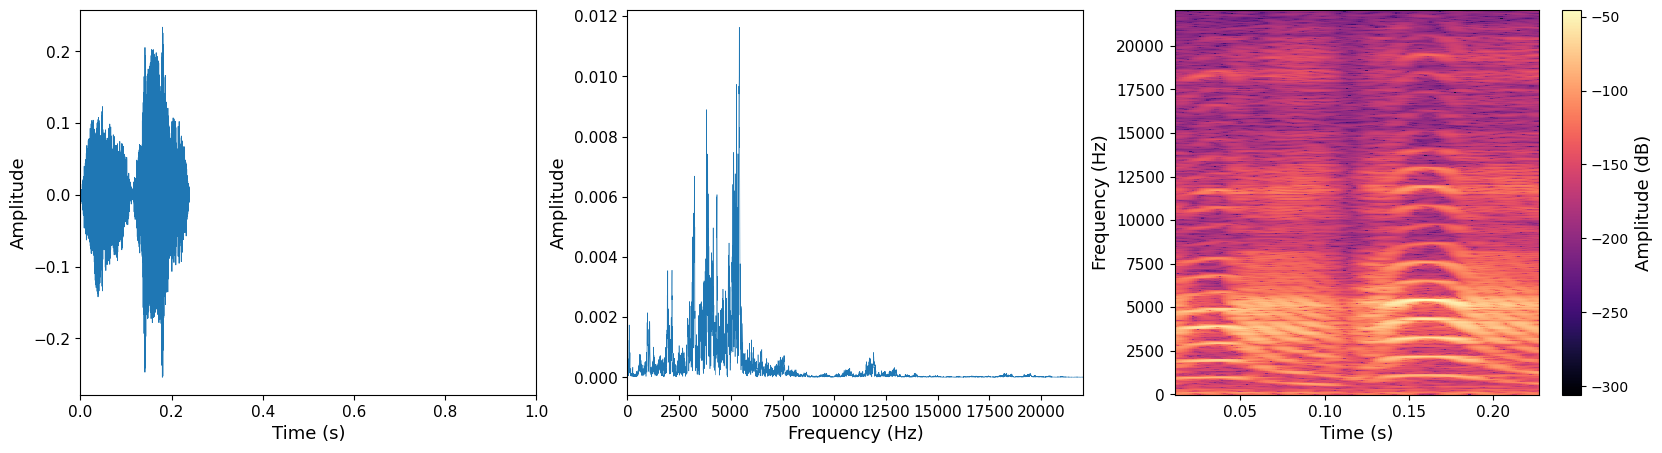

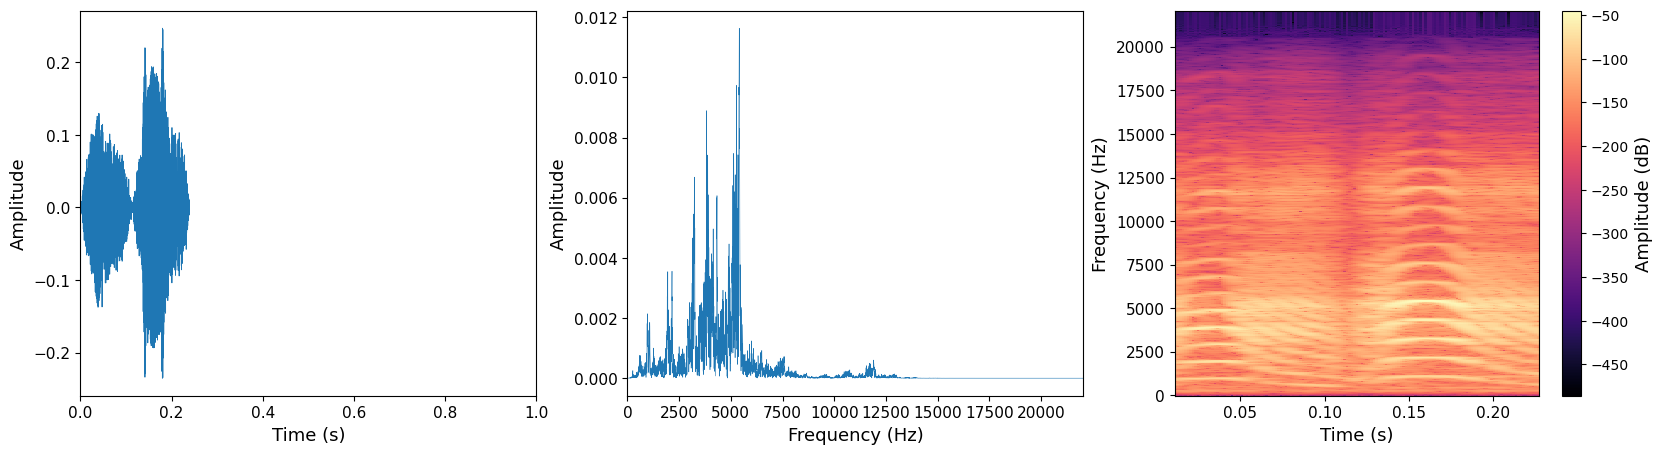

[2.56151866e-05 2.56151866e-05 2.56151866e-05 ... 2.56151866e-05
 2.56151866e-05 2.56151866e-05]


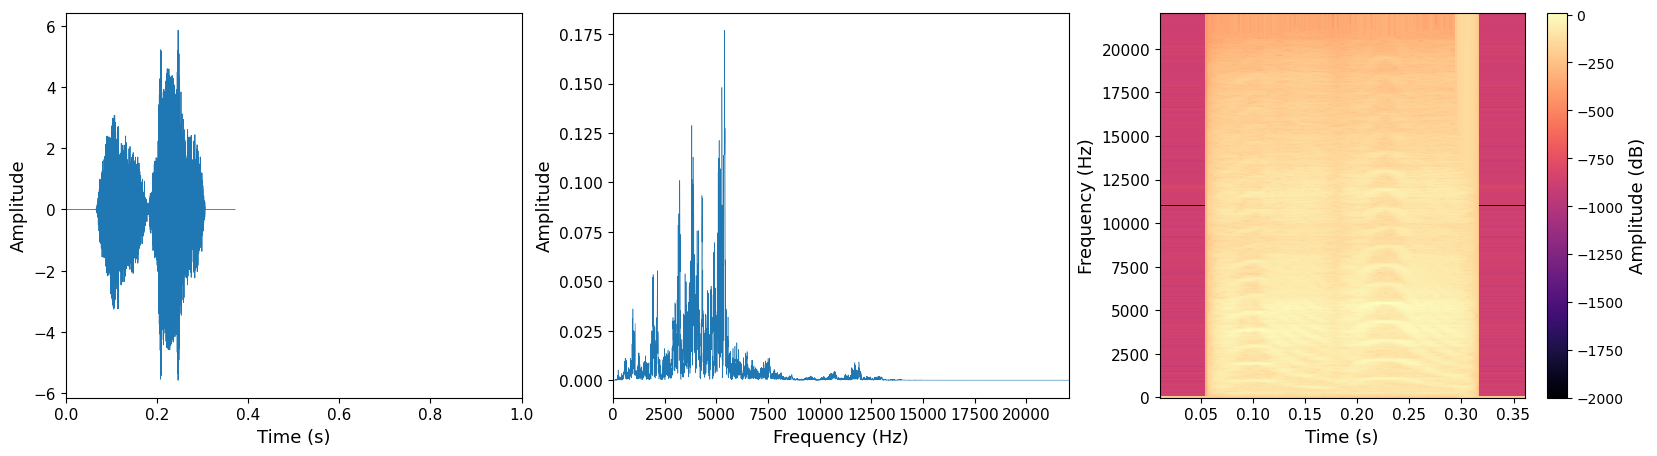

In [48]:
signal = df_top["rec"][2]
print(signal)
sr = 44100
create_plots(signal,sr)
filtered = bandpass_filter(signal,250,12000,sr)
create_plots(filtered,sr)
centred = centre_and_pad(filtered)
normalised = z_score_normalise(centred)
print(normalised)
create_plots(normalised, sr)


In [43]:
IPython.display.display(Audio(signal, rate =sr))
IPython.display.display(Audio(normalised, rate =sr))

In [34]:
def centre_and_pad(signal, slice_len= 16384):
    nsamples = len(signal)
    l_pad = (slice_len - nsamples)//2
    r_pad = slice_len - (nsamples + l_pad)
    if len(signal) < slice_len:
        padded_array = np.pad(signal,
                              (l_pad,r_pad),
                              mode = "constant")
        return padded_array
    else:
        signal = signal[:slice_len]
    return signal

(array([7.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.500e+01, 1.600e+01,
        2.800e+01, 3.900e+01, 4.700e+01, 4.300e+01, 4.700e+01, 4.800e+01,
        5.200e+01, 5.900e+01, 6.700e+01, 1.130e+02, 1.380e+02, 2.140e+02,
        3.160e+02, 3.820e+02, 5.380e+02, 6.270e+02, 7.460e+02, 1.051e+03,
        7.377e+03, 1.007e+03, 7.520e+02, 5.410e+02, 4.900e+02, 3.870e+02,
        2.790e+02, 2.090e+02, 1.530e+02, 1.460e+02, 1.110e+02, 7.500e+01,
        6.100e+01, 4.100e+01, 3.200e+01, 2.700e+01, 3.000e+01, 1.700e+01,
        1.900e+01, 1.800e+01, 6.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00]),
 array([-5.5748218 , -5.34625636, -5.11769092, -4.88912548, -4.66056004,
        -4.4319946 , -4.20342916, -3.97486372, -3.74629828, -3.51773284,
        -3.2891674 , -3.06060196, -2.83203652, -2.60347108, -2.37490564,
        -2.1463402 , -1.91777476, -1.68920932, -1.46064388, -1.23207844,
        -1.003513  , -0.77494756, -0.54638212, -0.31781669, -0.08925125,
         0.

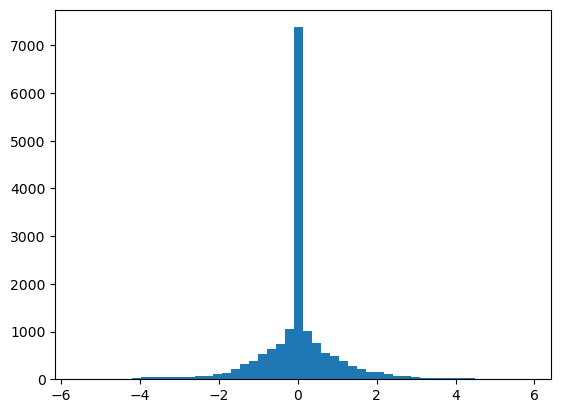

In [51]:
plt.hist(normalised, bins = 50)